In [1]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
import copy                               # for deep copies
import warnings
import json
import properscoring as ps
import random

In [2]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.dataset.util import to_pandas
from gluonts.evaluation import make_evaluation_predictions
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts.dataset.field_names import FieldName

from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
import scipy

In [3]:
#Display all of the rows in a dataframe
pd.set_option('display.max_rows', 10000)
warnings.filterwarnings("ignore")
sc = MinMaxScaler()
sens_analysis = False
pred_len = 60
random.seed(42)

In [4]:
filename = os.path.abspath('') + '\\Data\\Filtered\\FilteredProduction.xlsx'
file = open(filename, "rb")
prodDF = pd.read_excel(file, engine="openpyxl")

filename = os.path.abspath('') + '\\Data\\Filtered\\FilteredInjection.xlsx'
file = open(filename, "rb")
injectDF = pd.read_excel(file, engine="openpyxl")

filename = "LongestProductionWells.xlsx"
filename = os.path.abspath('') + "\\Data\\Use\\" + filename
file = open(filename, "rb")
testDF = pd.read_excel(file, engine='openpyxl')

In [5]:
###########    Injection by Unit     #########

# copyDF = prodDF
# copyInj = injectDF#

# use_unit = "Travers Ranch Red River Unit"

# p_units = prodDF.groupby(prodDF.Enhanced_Recovery_Unit)
# prodDF = p_units.get_group(use_unit)

# i_units = injectDF.groupby(injectDF.Enhanced_Recovery_Unit)
# injectDF = i_units.get_group(use_unit)

In [6]:
#prodDF = copyDF
#injectDF = copyInj

In [7]:
p_units = prodDF.groupby(prodDF.Enhanced_Recovery_Unit)
unit_wells = {}
for p_unit, data in p_units:
    unit_wells[p_unit] = pd.unique(data['Well_Name'])
    
well_units = {}
for key in unit_wells:
    wells = unit_wells[key]
    for w in wells:
        if (~(w in well_units.keys())):
            well_units[w] = key

In [8]:
#Group dataset by well
well_groups = prodDF.groupby(prodDF.Well_Name)
well_names = []
wells = []

prod_Data_Vol = 0

for well, data in well_groups:
    well_names.append(well)
    if (len(data) > pred_len):
        wells.append(data)
        prod_Data_Vol += len(well)
    
#test_wells = well_names                                  #Injection by Unit
test_groups = testDF.groupby(testDF.Well_Name)
test_wells = []
for well, data in test_groups:
    test_wells.append(well)
    
i_well_groups = injectDF.groupby(["Well_Name", "Enhanced_Recovery_Unit"])
i_wells = []
for i_well, data in i_well_groups:
    if (len(data) > pred_len):
        i_wells.append(data)

In [9]:
train_list = []
test_list = []
for x in wells:
    #well_name = pd.unique(x.Well_Name)[0]
    length = x.Oil_bbls.size

    covar_train = []
    covar_test = []
    
#     for i in i_wells:            #Injection: all wells
#         i_well = i
#         i_well = i_well.set_index(i_well.Date_Injection_Report)
#         i_well = i_well[~i_well.index.duplicated()]
#         if (x.Enhanced_Recovery_Unit.iloc[length - 1] == i_well.Enhanced_Recovery_Unit.iloc[len(i_well) - 1]):
#             i_well = i_well.reindex(x.Date_Production, fill_value=0)
#         else:
#             i_well = i_well.reindex(x.Date_Production)
#             i_well[:] = 0
        
#         if (sens_analysis):
#             #Set the test injection covariate values (to see effect)
#             ratio = 1.0    #Proportion to set all test injection values to
#             i_well.Vol_Fluid_Injected[int(length - pred_len):] = max(i_well.Vol_Fluid_Injected) * ratio
        
#         covar_train.append(i_well.Vol_Fluid_Injected[:int(length - pred_len)])
#         covar_test.append(i_well.Vol_Fluid_Injected)
        
#     covar_train = sc.fit_transform(covar_train)
#     covar_test = sc.fit_transform(covar_test)
    
    prod_days = sc.fit_transform(x.Prod_Days.values.reshape(-1, 1))
    prod_days = prod_days.reshape(1, -1)[0]
    
    covar_train = [prod_days[:int(length - pred_len)]]
    covar_test = [prod_days]
    
    #np.insert(covar_train, 0, prod_days[:int(length - pred_len)])
    #np.insert(covar_test, 0, prod_days)
    
    train_list.append({
        'target': x.Oil_bbls[:int(length - pred_len)],
        'start': x.iloc[0].Date_Production,
        'feat_dynamic_real': covar_train
    })
    test_list.append({
        'target': x.Oil_bbls,
        'start': x.iloc[0].Date_Production,
        'feat_dynamic_real': covar_test
    })
train_ds = ListDataset(train_list, freq="1M")
test_ds = ListDataset(test_list, freq="1M")

In [10]:
############     Injection by Sum     ########### 

#unit_volumes = injectDF.groupby(['Enhanced_Recovery_Unit', 'Date_Injection_Report'])['Vol_Fluid_Injected'].sum()
#inj_dict = {}
#for well, data in well_groups:
#    unit = data.iloc[0].Enhanced_Recovery_Unit
#    inj_dict[well] = unit_volumes[unit]
#    
#for well in wells:
#    well_name = well.iloc[0].Well_Name
#    inj_vols = inj_dict[well_name].reindex(well.Date_Production)
#    well['Injection_bbls'] = inj_vols.values
#    well['Injection_bbls'] = well['Injection_bbls'].fillna(0)

In [11]:
############     Injection by Sum     ########### 

#train_ds = ListDataset(
#    [{'target': x.Oil_bbls[:int(x.Oil_bbls.size - pred_len)], 'start': x.iloc[0].Date_Production,
#      'feat_dynamic_real': [x.Water_bbls[:int(x.Oil_bbls.size - pred_len)],
#                            #x.Injection_bbls[:int(x.Oil_bbls.size - pred_len)],
#                            x.Prod_Days[:int(x.Oil_bbls.size - pred_len)]]} for x in wells], freq="1M" 
#)
#test_ds = ListDataset(
#    [{'target': x.Oil_bbls, 'start': x.iloc[0].Date_Production,
#      'feat_dynamic_real': [x.Water_bbls, x.Prod_Days]} for x in wells], freq="1M"
#      #'feat_dynamic_real': [x.Water_bbls, x.Injection_bbls, x.Prod_Days]} for x in wells], freq="1M"
#)

In [12]:
#Some parameters have to be set in Trainer() ex: epochs, batches per epoch
#estimator = DeepAREstimator(freq="1M", prediction_length=pred_len, trainer=Trainer(),#(epochs=10),
#                            use_feat_dynamic_real=True)
random.seed(42)
estimator = DeepAREstimator(freq="1M", prediction_length=pred_len, trainer=Trainer(epochs=25),
                                #learning_rate=.0001,
                                #num_batches_per_epoch=100), 
                                use_feat_dynamic_real=False)  #Tuning without Injection!!!
                                #num_cells=40, num_layers=4, dropout_rate=.3, batch_size=32,
                                #context_length=None, cell_type='lstm')


predictor = estimator.train(training_data=train_ds)

100%|████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.15it/s, epoch=25/25, avg_epoch_loss=6.28]


In [13]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=10,  # number of sample paths we want for evaluation          #Tune this value???
)
forecasts = list(forecast_it)
tss = list(ts_it)

In [22]:
def plot_prob_forecasts(ts_entry, forecast_entry, well_name):
    plot_length = 700
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.15, top=1.0, wspace=0.2, hspace=0.2)
    plt.grid(which="both")
    plt.legend(legend, loc="upper right")
    plt.xlabel('year')
    plt.ylabel('Oil bbls')
    plt.title("Vanilla " + well_name + " Forecast")
    plt.show()

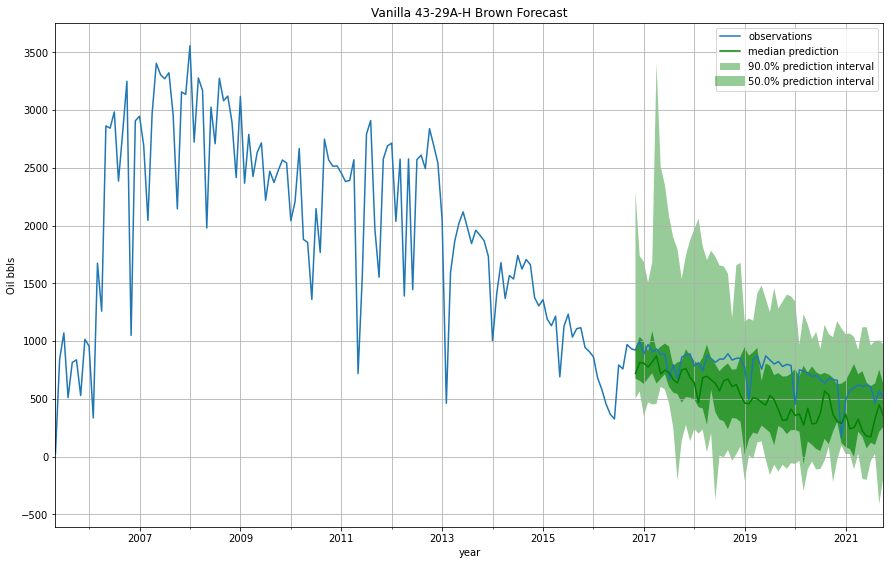

In [28]:
for i in range(len(tss)):
    if well_names[i] == "43-29A-H Brown": #in test_wells:
        plot_prob_forecasts(tss[i], forecasts[i], well_names[i])       

In [16]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(train_ds))
aggDF = pd.DataFrame([agg_metrics])
aggDF

Running evaluation: 100%|███████████████████████████████████████████████████████████| 328/328 [00:02<00:00, 118.40it/s]


,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],...,RMSE,NRMSE,ND,wQuantileLoss[0.1],wQuantileLoss[0.5],wQuantileLoss[0.9],mean_absolute_QuantileLoss,mean_wQuantileLoss,MAE_Coverage,OWA
0,182735.918448,4.077673e+06,1.091570e+07,554.659553,336.776682,0.740959,1.621122,0.430207,8.113075,1.776891e+06,...,427.47622,0.7707,0.37356,0.162783,0.37356,0.272665,2.943632e+06,0.26967,0.028506,NaN


In [17]:
crps_list = []
for i in range(len(tss)):
    crps = ps.crps_ensemble(tss[i][(len(tss[i]) - pred_len):][0].values, np.transpose(forecasts[i].samples)).mean()
    crps_list.append(crps)
    
item_metrics['Mean CRPS'] = crps_list
item_metrics['RMSE'] = item_metrics['MSE']**(.5)
agg_metrics['Mean CRPS'] = sum(crps_list)/len(crps_list)

In [18]:
aggDict = {'MAPE':round(agg_metrics['MAPE'], 3), 
           'Mean CRPS':round(agg_metrics['Mean CRPS'], 4)}
aggDF = pd.DataFrame([aggDict])
aggDF

,MAPE,Mean CRPS
0,1.621,166.708


In [19]:
unit_agg_dict = {}
for i in range(len(item_metrics)):
    unit_name = well_units[well_names[i]]
    if (unit_name in ["Alum Creek Unit", "Buffalo Red River Unit", "Central Buffalo Red River Unit",
                 "East Harding Springs Red River Unit", "North Buffalo Red River Unit",
                 "Pete's Creek Red River Unit", "South Buffalo Red River Unit",
                 "West Buffalo B Red River Unit", "West Buffalo Red River Unit"]):
        if unit_name in unit_agg_dict.keys():
            unit_agg_dict[unit_name].append(item_metrics.iloc[i])
        else:
            arr = [item_metrics.iloc[i]]
            unit_agg_dict[unit_name] = arr
                          
unit_metrics = []
for key in unit_agg_dict:
    sum_crps = 0
    sum_mape = 0
    for well in unit_agg_dict[key]:
        sum_crps += well["Mean CRPS"]
        sum_mape += well["MAPE"]
                          
    unit_metrics.append({"Unit Name": key, "Prod Data Volume":prod_Data_Vol,
                         "MAPE":sum_mape/len(unit_agg_dict[key]), "mCRPS":sum_crps/len(unit_agg_dict[key])})
unit_metrics_DF = pd.DataFrame(unit_metrics)

In [20]:
unit_metrics_DF.sort_values('Unit Name')

,Unit Name,Prod Data Volume,MAPE,mCRPS
4,Alum Creek Unit,5953,0.453627,59.211256
5,Buffalo Red River Unit,5953,2.849972,154.380931
2,Central Buffalo Red River Unit,5953,0.393432,551.492380
7,East Harding Springs Red River Unit,5953,1.339868,589.724281
6,North Buffalo Red River Unit,5953,0.932141,336.376782
3,Pete's Creek Red River Unit,5953,0.472439,323.544952
0,South Buffalo Red River Unit,5953,1.309466,142.754621
1,West Buffalo B Red River Unit,5953,3.937720,123.076747
8,West Buffalo Red River Unit,5953,1.369330,137.982547


In [21]:
top_metrics = []
for i in range(len(item_metrics)):
    item_metrics.item_id[i] = well_names[i]
    if well_names[i] in test_wells:
        top_metrics.append(item_metrics.iloc[i])
top_metrics_DF = pd.DataFrame(top_metrics)
top_metrics_DF.drop(columns=['MSE', 'abs_target_sum', 'MSIS', 'QuantileLoss[0.1]',
                            'QuantileLoss[0.5]', 'QuantileLoss[0.9]', 'seasonal_error', 'MASE', 'sMAPE', 'abs_error',
                            'Coverage[0.1]', 'Coverage[0.5]', 'Coverage[0.9]'])
top_metrics_DF = top_metrics_DF.rename(columns={"item_id": "Well Name", "abs_target_mean": "Mean Oil bbls"})
top_metrics_DF = top_metrics_DF[['Well Name', 'Mean Oil bbls', 'RMSE', 'Mean CRPS', 'MAPE']]
top_metrics_DF

,Well Name,Mean Oil bbls,RMSE,Mean CRPS,MAPE
36,BRRU 34-9 (Discovery Well),394.200000,94.589073,64.897324,0.281114
81,Graves 32-23 Clarkson WBRRU,623.716667,160.188275,95.238785,0.241380
84,Gulf 1 State Cave Hills,196.416667,72.500449,36.578171,1.007528
86,Helms 1 Coffing,33.753333,30.346351,15.034333,0.691065
195,Luff 41-22 Otterness,208.216667,150.094672,62.896458,0.437251
207,Luff-Hanover 1-7A Travers,345.883333,116.109741,78.641045,0.607605
211,Mid America 3-16 State BRRU,986.950000,360.415096,206.035156,0.294357
233,Phillips 1 Thune,254.500000,60.012954,45.609188,0.219870
253,SBRRU 14-28,408.166667,653.299523,196.339554,2.079967
270,SBRRU 34-11,242.950000,125.590754,74.176147,0.622328


In [45]:
top_metrics_copy_DF = pd.DataFrame(top_metrics_copy)
top_metrics_copy_DF.drop(columns=['MSE', 'abs_target_sum', 'MSIS', 'QuantileLoss[0.1]',
                            'QuantileLoss[0.5]', 'QuantileLoss[0.9]', 'seasonal_error', 'MASE', 'sMAPE', 'abs_error',
                            'Coverage[0.1]', 'Coverage[0.5]', 'Coverage[0.9]'])
top_metrics_copy_DF = top_metrics_copy_DF.rename(columns={"item_id": "Well Name", "abs_target_mean": "Mean Oil bbls"})
top_metrics_copy_DF = top_metrics_copy_DF[['Well Name', 'Mean Oil bbls', 'RMSE', 'Mean CRPS', 'MAPE']]
top_metrics_copy_DF

NameError: name 'top_metrics_copy' is not defined

In [ ]:
top_metrics_copy = top_metrics
agg_copy = agg_metrics
item_copy = item_metrics
forecast_copy = forecasts
tss_copy = tss

In [ ]:
for i in range(len(tss_copy)):
    if well_names[i] == "I-28H McKitrick": #in test_wells:
        plot_prob_forecasts(tss_copy[i], forecast_copy[i], well_names[i])  

In [25]:
#Vanilla: 1.399	164.4218
#Injection: 0.986	160.735
aggDict = pd.DataFrame({"Model Type":["Vanilla", "+Prod_Days"], "MAPE":[1.621, 0.911], "Mean CRPS":[166.708, 148.915]})
#pd.DataFrame([aggDict, aggDict_copy])
#aggDict.drop(columns="Type")
aggDict

,Model Type,MAPE,Mean CRPS
0,Vanilla,1.621,166.708
1,+Prod_Days,0.911,148.915
